# CNNs

In [1]:
# Import libraries to verify installation
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
import cv2
from PIL import Image
import random
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings("ignore")


2024-05-27 11:32:22.603362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 11:32:23.654907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.4/lib64:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-05-27 11:32:23.655067: W tensorflow/compiler/xla/stream_exec

## Loading the Data

In [2]:
# Check whether Tensorflow has enabled GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
TensorFlow version: 2.11.0


In [2]:
# Import the dataset
train_directory = './train'
test_directory = './test'
validation_directory = './valid'

train_img = [os.path.join(train_directory, f) for f in os.listdir(train_directory)]
test_img = [os.path.join(test_directory, f) for f in os.listdir(test_directory)]
valid_img = [os.path.join(validation_directory, f) for f in os.listdir(validation_directory)]

In [3]:
df_train = pd.read_csv("./birds.csv")
df_train.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [4]:
batch_size = 32

In [8]:
# Create an instance of ImageDataGenerator with desired augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Flow images from directory using the defined data generator
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 84635 images belonging to 525 classes.


In [9]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 2625 images belonging to 525 classes.


In [10]:
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(validation_directory,
                                                target_size=(224,224),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')

Found 2625 images belonging to 525 classes.


# CNN Model ResNet50

In [18]:
# Load the ResNet50 model with pretrained weights from ImageNet, excluding the top layers
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the ResNet50 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Add L2 regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Another Dropout layer for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [19]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
callbacks = [checkpoint_callback, early_stopping, reduce_lr]

In [20]:
#fit the model
history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch=len(train_generator),
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=callbacks)

timestamp = time.strftime("%Y%m%d-%H%M%S")
model.save(f'Resnet_15epochs_trianable{timestamp}.h5')

Epoch 1/15


2024-05-25 20:26:15.071215: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-25 20:26:15.071266: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-25 20:26:15.082580: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-25 20:26:15.082621: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

2645/2645 [==============================] - 909s 331ms/step - loss: 6.7543 - accuracy: 0.0427 - val_loss: 12.4253 - val_accuracy: 0.0530 - lr: 0.0010
Epoch 2/15
2645/2645 [==============================] - 879s 332ms/step - loss: 4.5516 - accuracy: 0.2522 - val_loss: 3.7133 - val_accuracy: 0.4773 - lr: 0.0010
Epoch 3/15
2645/2645 [==============================] - 875s 331ms/step - loss: 3.4916 - accuracy: 0.4560 - val_loss: 2.5686 - val_accuracy: 0.6606 - lr: 0.0010
Epoch 4/15
2645/2645 [==============================] - 864s 327ms/step - loss: 3.0515 - accuracy: 0.5509 - val_loss: 3.9452 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 5/15
2645/2645 [==============================] - 862s 326ms/step - loss: 2.7390 - accuracy: 0.6169 - val_loss: 2.7096 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 6/15
2645/2645 [==============================] - 863s 326ms/step - loss: 2.5187 - accuracy: 0.6610 - val_loss: 5.9528 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 7/15
2645/2645 [======================

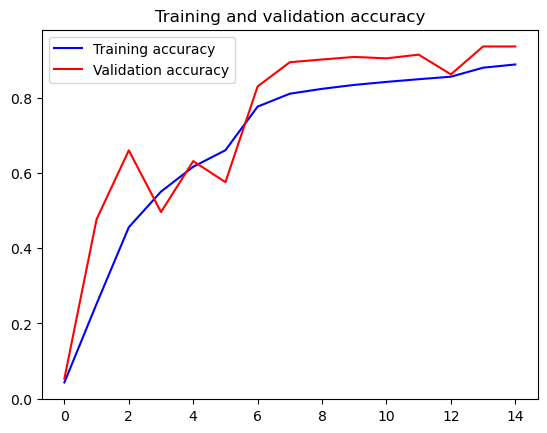

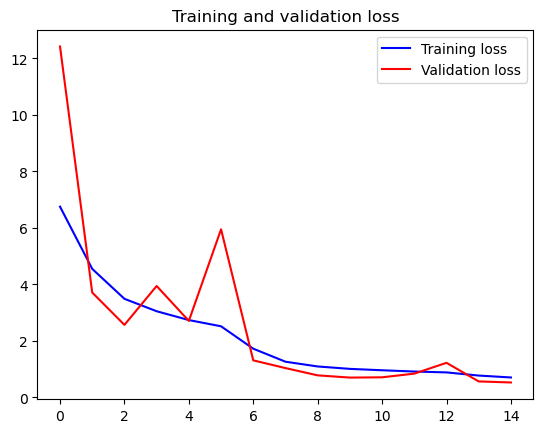

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
results = model.evaluate(test_generator)

print(f"Test accuracy: {results[1] * 100:.2f}%")
print(f"Test loss: {results[0]:.2f}")

83/83 [==============================] - 5s 60ms/step - loss: 0.4582 - accuracy: 0.9589
Test accuracy: 95.89%
Test loss: 0.46


### Hyperparameter Tuning

In [6]:
class MyHyperModel(kt.HyperModel):    
    def build(self, hp):
        # Define the structure of the model
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # Unfreeze layers based on hyperparameter
        trainable_layers = hp.Int('trainable_layers', min_value=50, max_value=len(base_model.layers), step=10)
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        
        # Dropout rate as hyperparameter
        dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.05)
        x = Dropout(dropout_rate)(x)
        
        x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        
        predictions = Dense(525, activation='softmax')(x)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        
        # Learning rate as hyperparameter
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='LOG')
        optimizer = Adam(learning_rate=learning_rate)
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        return model

In [7]:
from keras_tuner import BayesianOptimization

tuner = BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=20,
    directory='tuner_dir',
    project_name='Resnet50_Fine_Tuning'
)

tuner.search_space_summary()

Reloading Tuner from tuner_dir/Resnet50_Fine_Tuning/tuner0.json
Search space summary
Default search space size: 3
trainable_layers (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 175, 'step': 10, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [5]:
batch_size = 32

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.75)

In [10]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training')

val_generator = val_datagen.flow_from_directory(
    validation_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')


Found 21347 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [5]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Watch validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Watch validation loss
    factor=0.2,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6           # Lower bound on the learning rate
)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Path to save the best model
    monitor='val_accuracy',    # Watch validation accuracy
    save_best_only=True,       # Save only the best model
    save_weights_only=False,   # Save the entire model, including weights and architecture
    mode='max'                 # Mode for monitoring the quantity to be maximized (accuracy in this case)
)

# Add the callbacks to a list
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [16]:
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks,
    verbose=1
)

Trial 20 Complete [00h 19m 43s]
val_accuracy: 0.7577142715454102

Best val_accuracy So Far: 0.7931428551673889
Total elapsed time: 09h 28m 05s


In [17]:
tuner.results_summary()

best_model = tuner.get_best_models(num_models=1)[0]

Results summary
Results in tuner_dir/Resnet50_Fine_Tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 10 summary
Hyperparameters:
trainable_layers: 160
dropout_rate: 0.5
learning_rate: 0.0001
Score: 0.7931428551673889

Trial 12 summary
Hyperparameters:
trainable_layers: 160
dropout_rate: 0.5
learning_rate: 0.0001
Score: 0.7756190299987793

Trial 17 summary
Hyperparameters:
trainable_layers: 160
dropout_rate: 0.5
learning_rate: 0.00010685348248246104
Score: 0.7649523615837097

Trial 19 summary
Hyperparameters:
trainable_layers: 160
dropout_rate: 0.5
learning_rate: 0.00010321952730594419
Score: 0.7577142715454102

Trial 13 summary
Hyperparameters:
trainable_layers: 160
dropout_rate: 0.5
learning_rate: 0.00011605547997087965
Score: 0.7420952320098877

Trial 16 summary
Hyperparameters:
trainable_layers: 140
dropout_rate: 0.5
learning_rate: 0.0001
Score: 0.5512381196022034

Trial 09 summary
Hyperparameters:
trainable_layers: 140
dropout_rate: 0.5
learning_r

In [5]:
import json

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def access_score(data):
    return data['score']

In [6]:
#get all the file paths in tuner_dir/Resnet50_Fine_Tuning

tuner_dir = 'tuner_dir/Resnet50_Fine_Tuning'
tuner_subdirs = [os.path.join(tuner_dir, f) for f in os.listdir(tuner_dir) if os.path.isdir(os.path.join(tuner_dir, f))]

# Get the scores from each trial
scores = []
for subdir in tuner_subdirs:
    trial = read_json(os.path.join(subdir, 'trial.json'))
    score = access_score(trial)
    scores.append(score)
    
# get the best model

best_trial = tuner_subdirs[np.argmax(scores)]

# load hyperparameters of the best trial

best_hyperparameters = read_json(os.path.join(best_trial, 'trial.json'))['hyperparameters']['values']
best_hyperparameters

{'trainable_layers': 160, 'dropout_rate': 0.5, 'learning_rate': 0.0001}

### Training on best hyperparameters

In [7]:
# Define the structure of the model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze layers based on hyperparameter

trainable_layers = best_hyperparameters['trainable_layers']
for layer in base_model.layers[:-trainable_layers]:
    layer.trainable = False
for layer in base_model.layers[-trainable_layers:]:
    layer.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Dropout rate as hyperparameter

dropout_rate = best_hyperparameters['dropout_rate']
x = Dropout(dropout_rate)(x)

x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

predictions = Dense(525, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Learning rate as hyperparameter

learning_rate = best_hyperparameters['learning_rate']
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-05-27 11:32:59.133354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 11:33:01.066488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7243 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
# train on full dataset

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 84635 images belonging to 525 classes.


In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    validation_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 2625 images belonging to 525 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 2625 images belonging to 525 classes.


In [13]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Watch validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Watch validation loss
    factor=0.2,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7           # Lower bound on the learning rate
)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='Resnet50_50epochs_fulldataset.h5',  # Path to save the best model
    monitor='val_accuracy',    # Watch validation accuracy
    save_best_only=True,       # Save only the best model
    save_weights_only=False,   # Save the entire model, including weights and architecture
    mode='max'                 # Mode for monitoring the quantity to be maximized (accuracy in this case)
)

# Add the callbacks to a list
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [19]:
history = model.fit(train_generator, 
                    epochs = 50, 
                    steps_per_epoch=len(train_generator), 
                    validation_data=val_generator,
                    validation_steps=len(val_generator), 
                    callbacks=callbacks)

timestamp = time.strftime("%Y%m%d-%H%M%S")
model.save(f'Resnet50_fine_tuned_full_dataset{timestamp}.h5')

Epoch 1/50


2024-05-27 11:38:34.578018: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5555e9a22eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-27 11:38:34.578060: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-05-27 11:38:34.588613: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-27 11:38:34.721920: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2645/2645 [==============================] - 935s 339ms/step - loss: 11.6751 - accuracy: 0.3432 - val_loss: 5.0200 - val_accuracy: 0.8328 - lr: 1.0000e-04
Epoch 2/50
2645/2645 [==============================] - 891s 337ms/step - loss: 3.6104 - accuracy: 0.7382 - val_loss: 1.7868 - val_accuracy: 0.9166 - lr: 1.0000e-04
Epoch 3/50
2645/2645 [==============================] - 887s 335ms/step - loss: 1.7750 - accuracy: 0.8179 - val_loss: 1.0679 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 4/50
2645/2645 [==============================] - 863s 326ms/step - loss: 1.2667 - accuracy: 0.8507 - val_loss: 0.8311 - val_accuracy: 0.9425 - lr: 1.0000e-04
Epoch 5/50
2645/2645 [==============================] - 865s 327ms/step - loss: 1.0767 - accuracy: 0.8683 - val_loss: 0.7556 - val_accuracy: 0.9429 - lr: 1.0000e-04
Epoch 6/50
2645/2645 [==============================] - 864s 327ms/step - loss: 0.9751 - accuracy: 0.8812 - val_loss: 0.7468 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 7/50
2645/2645

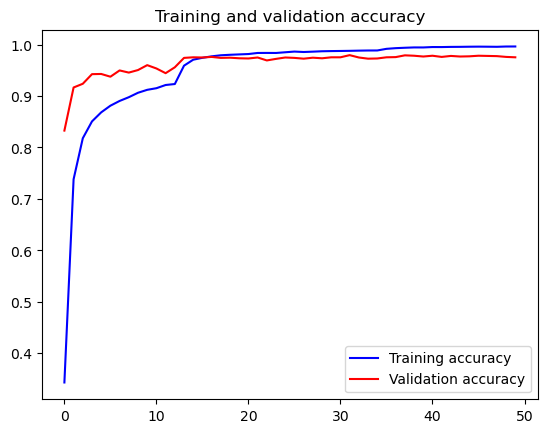

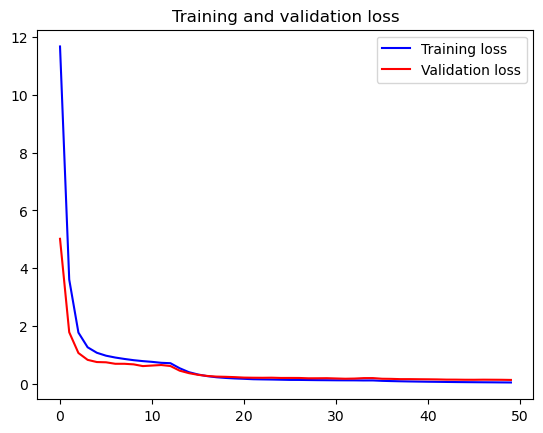

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
# save history to a pickle file
import pickle

with open(f'history_resnet50_fine_tuned_full_dataset{timestamp}.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
with open(f'history_resnet50_fine_tuned_full_dataset{timestamp}.pkl', 'rb') as file:
    history = pickle.load(file)

In [25]:
best_model = load_model('Resnet50_50epochs_fulldataset.h5')

results = best_model.evaluate(test_generator)

print(f"Test accuracy: {results[1] * 100:.2f}%")
print(f"Test loss: {results[0]:.2f}")

83/83 [==============================] - 6s 61ms/step - loss: 0.1234 - accuracy: 0.9890
Test accuracy: 98.90%
Test loss: 0.12
